# Predict me using Keras

- Test Sequential APIs
- Save and Restore model
- Using Call Backs
- Tensorboard with different hyper params
- Fine Tuning your Model
- Use the last model in the FastAPIs

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
from scipy.stats import reciprocal
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse
import time
import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Keras APIs
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras import models
from tensorflow import keras
import tensorflow as tf

from configs import *
from keras_sequential_model import *
from keras_functional_model import *
warnings.filterwarnings('ignore')
%matplotlib inline


# Build Tensor Visualization

Keras provide us with tensor vislization a helpfull tool(can be used with your web browser or even in the notebook), this tool help us see the different runs we have made and see the result of training model during each epochs.

Beside of that we need to save the best parameters on the validation set in each run, to decide which run we will use later in our APIS, to make prediction.

## Get 100 * 100 images

100
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 30000)
(97, 30000)
(1, 600)
(1, 97)
===================After===================
(30000, 600)
(30000, 97)
(1, 600)
(1, 97)


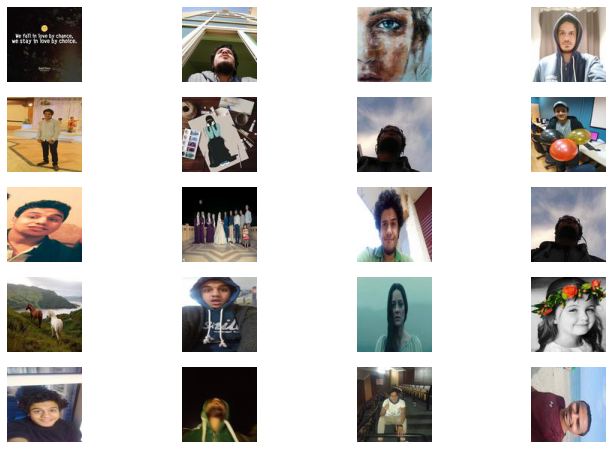

In [2]:
df_all_images = images_pipeline(100, "_100_100_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 100)

## Split the data

In [3]:
X_train, X_val, y_train, y_val = X_train.T, X_val.T, y_train.T, y_val.T
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3)

## Search for the best hyper paramters

In [4]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[X_train.shape[1]]):
    '''
    The function used to help us searching for best hyper paramters using sklearn along with keras.
    other optional parameters we can pass like metrics.

    Argument:
        n_hidden      : How many hidden layers we need
        n_neurons     : For each hidden layer which number of neurons we need (fixed number for all hidden layers)
        learning_rate : How to control the steps the model take during training
        input_shape   : The number of features we have defined by the image (width * height * 3 for rgb)
    
    return:
        model: The architecture of the model we have built and compiled 
    '''
        
     # Create the Sequential model
    model = keras.models.Sequential()
     # define the shape of the input layer from the features we have for each image
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
     # loop over hidden layers
    for i in range(n_hidden):
        
        # for each hidden layer pass the number of neurons for this layer
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
        
    # at the end handle the output layer as we just need to predict image belong to me or not so its just one unit
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=['acc'])
    return model

## First Search

In [5]:
param_distribs = {
     "n_hidden": [1, 2, 3, 4],
     "n_neurons": np.arange(1, 100),
     "learning_rate": reciprocal(3e-3, 2e0), # 3e-3 is 0.003 and 2e0 means 2.0
}

n_iter=1
rnd_search_cv = random_search(param_distribs, build_model, n_iter, X_train, y_train, X_val, y_val)



Epoch 1/100
13/13 [==============================] - 1s 19ms/step - loss: 0.6848 - acc: 0.5650 - val_loss: 0.7191 - val_acc: 0.5224
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6759 - acc: 0.5575 - val_loss: 0.6973 - val_acc: 0.4328
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6791 - acc: 0.5850 - val_loss: 0.6915 - val_acc: 0.5075
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6722 - acc: 0.6075 - val_loss: 0.7099 - val_acc: 0.5373
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6643 - acc: 0.6275 - val_loss: 0.7182 - val_acc: 0.5373
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6621 - acc: 0.6050 - val_loss: 0.7009 - val_acc: 0.5075
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6586 - acc: 0.6200 - val_loss: 0.6953 - val_acc: 0.5224
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6490 - 

13/13 [==============================] - 0s 8ms/step - loss: 0.6256 - acc: 0.6775 - val_loss: 0.6698 - val_acc: 0.5522
Epoch 28/100
13/13 [==============================] - 0s 7ms/step - loss: 0.5676 - acc: 0.7200 - val_loss: 0.6792 - val_acc: 0.5373
Epoch 29/100
13/13 [==============================] - 0s 7ms/step - loss: 0.5618 - acc: 0.7225 - val_loss: 0.6863 - val_acc: 0.5970
Epoch 30/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5439 - acc: 0.7225 - val_loss: 0.7198 - val_acc: 0.6269
Epoch 31/100
13/13 [==============================] - 0s 7ms/step - loss: 0.5589 - acc: 0.7375 - val_loss: 0.7191 - val_acc: 0.6269
Epoch 32/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5893 - acc: 0.7175 - val_loss: 0.8086 - val_acc: 0.5075
Epoch 33/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5844 - acc: 0.6725 - val_loss: 1.0066 - val_acc: 0.5224
Epoch 34/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6349 - acc: 0

In [6]:
 rnd_search_cv.best_params_

{'learning_rate': 0.012309534752094682, 'n_hidden': 4, 'n_neurons': 28}

In [7]:
model, history, model_hyper_params = train_sequential_model_with_best_params(rnd_search_cv, X_train, y_train,
                                                                             X_val, y_val, "img_size_100*100*3_")

Epoch 1/100
19/19 [==============================] - 1s 16ms/step - loss: 0.7001 - acc: 0.4917 - val_loss: 0.6948 - val_acc: 0.5373
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6889 - acc: 0.5333 - val_loss: 0.6926 - val_acc: 0.5075
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 0.6881 - acc: 0.5533 - val_loss: 0.6862 - val_acc: 0.5075
Epoch 4/100
19/19 [==============================] - 0s 12ms/step - loss: 0.6840 - acc: 0.5267 - val_loss: 0.6989 - val_acc: 0.5075
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6821 - acc: 0.5483 - val_loss: 0.6911 - val_acc: 0.5075
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6666 - acc: 0.6200 - val_loss: 0.6797 - val_acc: 0.5672
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6571 - acc: 0.6167 - val_loss: 0.6940 - val_acc: 0.4776
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6535 

In [8]:
model = save_model_best_weights(model, model_hyper_params)

In [9]:
model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 4ms/step - loss: 0.6545 - acc: 0.5970


[0.6544610261917114, 0.5970149040222168]

In [10]:
model, history, model_hyper_params = train_functional_model_with_best_params(rnd_search_cv, X_train, y_train, 
             X_val, y_val, "one_input_functional_api",  img_size="img_size_100*100*3_")

Epoch 1/100
19/19 [==============================] - 1s 19ms/step - loss: 8.7191 - accuracy: 0.5117 - val_loss: 2.5438 - val_accuracy: 0.5224
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 8.4227 - accuracy: 0.5417 - val_loss: 19.0984 - val_accuracy: 0.5075
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 10.2202 - accuracy: 0.5133 - val_loss: 2.2150 - val_accuracy: 0.5373
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 6.6479 - accuracy: 0.5583 - val_loss: 16.1146 - val_accuracy: 0.5075
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 7.7728 - accuracy: 0.5600 - val_loss: 11.1800 - val_accuracy: 0.5075
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 7.9650 - accuracy: 0.5567 - val_loss: 4.6567 - val_accuracy: 0.4925
Epoch 7/100
19/19 [==============================] - 0s 10ms/step - loss: 4.5243 - accuracy: 0.6217 - val_loss: 9.6323 - val_accuracy: 0.5075
Ep

In [11]:
model = save_model_best_weights(model, model_hyper_params)

In [12]:
model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 4ms/step - loss: 2.2150 - accuracy: 0.5373


[2.21502947807312, 0.5373134613037109]